In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
!pip install libsvm
from libsvm.svmutil import *
from scipy.spatial.distance import cdist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp310-cp310-linux_x86_64.whl size=251409 sha256=63ee1c113c12a44ebf98337e1549c21c67ba861a4e89bdccd4b022983e605e62
  Stored in directory: /root/.cache/pip/wheels/79/c7/19/a8c85928f8e629654b8e1adb3c8091f0bb77344d0ee9954a85
Successfully built libsvm


/usr/local/lib/python3.10/dist-packages/libsvm/svm.py:149: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def csr_to_problem_jit(l, x_val, x_ind, x_rowptr, prob_val, prob_ind, prob_rowptr, indx_start):


True


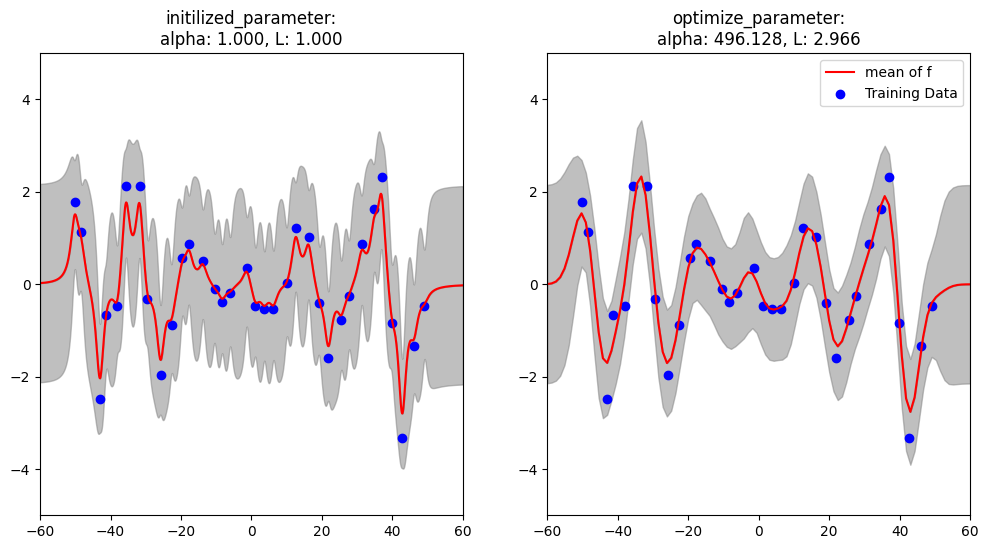

In [ ]:
#-----------------Gaussian process-----------------#
data = np.zeros((34,2))
with open('/content/input.data', 'r') as file:
    lines = file.readlines()
    count = 0
    for line in lines:
        data[count][0], data[count][1] = map(float, line.split())
        count += 1

def kernel(x1, x2, alpha=1, L=1):
    return (1 + ((x1 - x2)**2 / (2 * alpha * L * L))) ** (-alpha)

def log_likelihood_obj(par):
    alpha,L = par
    kernel_matrix = np.zeros((34,34))
    for i in range(34):
        for j in range(34):
            if i==j :
                kernel_matrix[i][j] = kernel(data[i][0],data[j][0], alpha, L) + (1/5)
            else:
                kernel_matrix[i][j] = kernel(data[i][0],data[j][0], alpha, L)
    return (1/2) * math.log(np.linalg.det(kernel_matrix)+1e-8) + (1/2) * data[:,1].T @ np.linalg.inv(kernel_matrix) @ data[:,1] + 17 * math.log(2*math.pi)


if __name__ == '__main__':
    #compute matrix C^-1
    C = np.zeros((34,34))
    for i in range(34):
        for j in range(34):
            if i==j :
                C[i][j] = kernel(data[i][0],data[j][0]) + (1/5)
            else:
                C[i][j] = kernel(data[i][0],data[j][0])
    C_inv = np.linalg.inv(C)

    #Draw a line to represent mean of f and 95% confidence interval of f
    x = np.linspace(-60,60,1200)
    y = np.zeros((1200))
    y_2std_add = np.zeros((1200))
    y_2std_min = np.zeros((1200))
    for i in range(1200):
        k = np.zeros((34,1))
        for j in range(34):
            k[j][0] = kernel(data[j][0],x[i])
        mean = k.T @ C_inv @ data[:,1]
        var = kernel(x[i],x[i]) + (1/5) - k.T @ C_inv @ k

        y[i] = mean[0]
        y_2std_add[i] = mean[0] + 1.96 * math.sqrt(var[0])
        y_2std_min[i] = mean[0] - 1.96 * math.sqrt(var[0])

    # Plot on the first subplot
    fig, axes = plt.subplots(1, 2,figsize=(12,6))
    axes[0].plot(x, y, label='mean of f',color='red')
    axes[0].set_xlim(-60, 60)
    axes[0].set_ylim(-5, 5)
    axes[0].fill_between(x, y, y_2std_add, color='gray', alpha=0.5)
    axes[0].fill_between(x, y, y_2std_min, color='gray', alpha=0.5)
    axes[0].scatter(data[:,0], data[:,1],label='Training Data', color='blue', marker='o')
    axes[0].set_title('initilized_parameter:\nalpha: {:.3f}, L: {:.3f}'.format(1,1))

    #--------------------------Task 2--------------------------#
    #Use scipy.optimize.minimize to find optimal parameters
    result = minimize(log_likelihood_obj, [1e0,1e0] ,bounds=((1e-4, 1e8), (1e0, 1e6)))
    alpha, L = result.x #optimal value of alpha and L
    #Use optimal value of parameters to compute matrix C^-1
    C = np.zeros((34,34))
    for i in range(34):
        for j in range(34):
            if i==j :
                C[i][j] = kernel(data[i][0],data[j][0], alpha, L) + (1/5)
            else:
                C[i][j] = kernel(data[i][0],data[j][0], alpha, L)
    C_inv = np.linalg.inv(C)

    #Draw a line to represent mean of f and 95% confidence interval of f
    x = np.linspace(-60,60,1200)
    y = np.zeros((1200))
    y_2std_add = np.zeros((1200))
    y_2std_min = np.zeros((1200))

    for i in range(1200):
        k = np.zeros((34,1))
        for j in range(34):
            k[j][0] = kernel(data[j][0],x[i], alpha, L)
        mean = k.T @ C_inv @ data[:,1]
        var = kernel(x[i],x[i], alpha, L) + (1/5) - k.T @ C_inv @ k

        y[i] = mean[0]
        y_2std_add[i] = mean[0] + 1.96 * math.sqrt(var[0])
        y_2std_min[i] = mean[0] - 1.96 * math.sqrt(var[0])
    # Plot on the second subplot
    axes[1].plot(x, y, label='mean of f',color='red')
    axes[1].set_xlim(-60, 60)
    axes[1].set_ylim(-5, 5)
    axes[1].fill_between(x, y, y_2std_add, color='gray', alpha=0.5)
    axes[1].fill_between(x, y, y_2std_min, color='gray', alpha=0.5)
    axes[1].scatter(data[:,0], data[:,1],label='Training Data', color='blue', marker='o')
    axes[1].set_title('optimize_parameter:\nalpha: {:.3f}, L: {:.3f}'.format(alpha,L))
    plt.legend()
    plt.show()

In [2]:
#------------------------------SVM Task 1------------------------------#
#read training data
file = open('/content/X_train.csv', 'r')
lines = file.read()
training_x = []
for line in lines.split('\n'):
    pixels = line.split(',')
    training_x.append({(i+1):float(pixels[i]) for i in range(len(pixels)) if pixels[i].strip()})
training_x.pop()

#read training label
file = open('/content/Y_train.csv', 'r')
lines = file.read()
training_y = []
for line in lines.split('\n'):
    if line.strip():
        training_y.append(int(line))

#read testing data
file = open('/content/X_test.csv', 'r')
lines = file.read()
testing_x = []
for line in lines.split('\n'):
    pixels = line.split(',')
    testing_x.append({(i+1):float(pixels[i]) for i in range(len(pixels)) if pixels[i].strip()})
testing_x.pop()

#read testing label
file = open('/content/Y_test.csv', 'r')
lines = file.read()
testing_y = []
for line in lines.split('\n'):
    if line.strip():
        testing_y.append(int(line))

#generate the training data with labels
training = svm_problem(training_y, training_x)

#training svm on three different kernel function( 0:linear, 1: polynomial, 2: RBF )
linear_model = svm_train(training, svm_parameter('-q -t 0'))
poly_model = svm_train(training, svm_parameter('-q -t 1'))
RBF_model = svm_train(training, svm_parameter('-q -t 2'))

#prdict testing data, output is accuracy
print("predict with linear kernel model: ")
linear_label, linear_acc, linear_vals = svm_predict(testing_y, testing_x, linear_model)
print("\npredict with polynomial kernel model: ")
poly_label, poly_acc, poly_vals = svm_predict(testing_y, testing_x, poly_model)
print("\npredict with RBF kernel model: ")
RBF_label, RBF_acc, RBF_vals = svm_predict(testing_y, testing_x, RBF_model)

predict with linear kernel model: 
Accuracy = 95.08% (2377/2500) (classification)

predict with polynomial kernel model: 
Accuracy = 34.68% (867/2500) (classification)

predict with RBF kernel model: 
Accuracy = 95.32% (2383/2500) (classification)


In [9]:
#------------------------------SVM Task 2------------------------------#

#grid search for RBF kernel
best_acc_RBF = 0
best_c_RBF = 0
best_g_RBF = 0
valueChoice_lgc = [-8, -6, -4, -2, 0]
valueChoice_lgg = [-8, -6, -4, -2, 0]
results_RBF = np.zeros((5,5))
for i, lgc_RBF in enumerate(valueChoice_lgc):
    for j, lgg_RBF in enumerate(valueChoice_lgg):
        parameter = svm_parameter(f'-q -v 3 -t 2 -c {math.e**lgc_RBF} -g {math.e**lgg_RBF}')
        model = svm_train(training, parameter)
        results_RBF[i][j] = round(model, 2)
        if results_RBF[i][j] >  best_acc_RBF:
            best_acc_RBF = results_RBF[i][j]
            best_c_RBF = lgc_RBF
            best_g_RBF = lgg_RBF

best_parameter = svm_parameter(f'-q -t 2 -c {math.e**best_c_RBF} -g {math.e**best_g_RBF}')
model = svm_train(training, best_parameter)
_, test_RBF, _ = svm_predict(testing_y, testing_x, model)


#grid search for polynomial kernel
best_acc_poly = 0
best_d_poly = 0
best_c_poly = 0
valueChoice_d = [0, 2, 4, 6, 8 ,10]
valueChoice_lgc = [-8, -6, -4, -2, 0]
results_poly = np.zeros((6,5))

for i, d in enumerate(valueChoice_d):
    for j, lgc in enumerate(valueChoice_lgc):
        parameter = svm_parameter(f'-q -v 3 -t 1 -d {d} -c {math.e**lgc}')
        model = svm_train(training, parameter)
        results_poly[i][j] = round(model, 2)
        if results_poly[i][j] >  best_acc_poly:
            best_acc_poly = results_poly[i][j]
            best_d_poly = d
            best_c_poly = lgc

best_parameter = svm_parameter(f'-q -t 1 -d {best_d_poly} -c {math.e**best_c_poly}')
model = svm_train(training, best_parameter)
_, test_poly, _ = svm_predict(testing_y, testing_x, model)

#grid search for linear kernel
best_acc_linear = 0
best_c_linear = 0
valueChoice_lgc_L = [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]
results_linear = np.zeros((11))

for i, lgc in enumerate(valueChoice_lgc_L):
    parameter = svm_parameter(f'-q -v 3 -t 0 -c {math.e**lgc}')
    model = svm_train(training, parameter)
    results_linear[i] = round(model, 2)
    if results_linear[i] >  best_acc_linear:
        best_acc_linear = results_linear[i]
        best_c_linear = lgc

best_parameter = svm_parameter(f'-q -t 0 -c {math.e**best_c_linear}')
model = svm_train(training, best_parameter)
_, test_linear, _ = svm_predict(testing_y, testing_x, model)

#save results to excel
#RBF results
row_labels = ["c: e**" + str(i) for i in valueChoice_lgc]
column_labels = ["g: e**" + str(i) for i in valueChoice_lgg]
df = pd.DataFrame(results_RBF, index=row_labels, columns=column_labels)
excel_file_path = "RBF_grid_results.xlsx"
df.to_excel(excel_file_path, index=True)

#polynomial results
row_labels = ["d: " + str(i) for i in valueChoice_d]
column_labels = ["c: e**" + str(i) for i in valueChoice_lgc]
df = pd.DataFrame(results_poly, index=row_labels, columns=column_labels)
excel_file_path = "polynomail_grid_results.xlsx"
df.to_excel(excel_file_path, index=True)

#linear results
row_labels = ["c: e**" + str(i) for i in valueChoice_lgc_L]
df = pd.DataFrame(results_linear, index=row_labels)
excel_file_path = "linear_grid_results.xlsx"
df.to_excel(excel_file_path, index=True)

#print results
print("------------------------------------------------------------------------------------------")
print("The best parameter for RBF kernel:")
print(f"c: e**{best_c_RBF}")
print(f"g: e**{best_g_RBF}")
print(f"model training performance: {best_acc_RBF}")
print(f"model testing performance: {test_RBF[0]}")
print("------------------------------------------------------------------------------------------")
print("The best parameter for Polynomial kernel:")
print(f"d: {best_d_poly}")
print(f"g: e**{best_c_poly}")
print(f"model training performance: {best_acc_poly}")
print(f"model testing performance: {test_poly[0]}")
print("------------------------------------------------------------------------------------------")
print("The best parameter for Linear kernel:")
print(f"c: e**{best_c_linear}")
print(f"model training performance: {best_acc_linear}")
print(f"model testing performance: {test_linear[0]}")
print("------------------------------------------------------------------------------------------")

Cross Validation Accuracy = 79.86%
Cross Validation Accuracy = 83.08%
Cross Validation Accuracy = 92.98%
Cross Validation Accuracy = 39.12%
Cross Validation Accuracy = 20.82%
Cross Validation Accuracy = 80.2%
Cross Validation Accuracy = 82.94%
Cross Validation Accuracy = 92.76%
Cross Validation Accuracy = 40.32%
Cross Validation Accuracy = 20.54%
Cross Validation Accuracy = 80.08%
Cross Validation Accuracy = 87.26%
Cross Validation Accuracy = 94.22%
Cross Validation Accuracy = 40.52%
Cross Validation Accuracy = 20.48%
Cross Validation Accuracy = 87.74%
Cross Validation Accuracy = 94.82%
Cross Validation Accuracy = 96.88%
Cross Validation Accuracy = 45.18%
Cross Validation Accuracy = 20.84%
Cross Validation Accuracy = 95%
Cross Validation Accuracy = 96.68%
Cross Validation Accuracy = 98.14%
Cross Validation Accuracy = 81.34%
Cross Validation Accuracy = 29.48%
Accuracy = 98.24% (2456/2500) (classification)
Cross Validation Accuracy = 20%
Cross Validation Accuracy = 20%
Cross Validation A

In [3]:
#------------------------------SVM Task 3------------------------------#
def new_kernel(x1,x2,w,g):
    data = np.zeros((len(x1), len(x2) + 1))
    linear = x1 @ x2.T
    RBF = np.exp(- math.e**g * cdist(x1, x2, 'sqeuclidean'))
    data[:, 1:] = w* linear + (1-w) * RBF
    data[:, :1] = np.arange(len(x1))[:, np.newaxis]+1
    return data

wChoice = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
valueChoice_lgg = [-4, -2, 0, 2, 4]
best_acc_con = 0
best_w_con = 0
best_g_con = 0
result_con = np.zeros((6,5))
for i, w in enumerate(wChoice):
    for j, lgg in enumerate(valueChoice_lgg):
        data = new_kernel(np.array([list(data.values()) for data in training_x]), np.array([list(data.values()) for data in training_x]), w, lgg)
        param = f"-q -t 4 -v 3"
        model = svm_train(training_y, [list(row) for row in data], param)
        result_con[i][j] = round(model, 2)
        if result_con[i][j] >  best_acc_con:
            best_acc_con = result_con[i][j]
            best_w_con = w
            best_g_con = lgg

data = new_kernel(np.array([list(data.values()) for data in training_x]), np.array([list(data.values()) for data in training_x]), best_w_con, best_g_con)
data_t = new_kernel(np.array([list(data.values()) for data in testing_x]), np.array([list(data.values()) for data in training_x]), best_w_con, best_g_con)
param = f"-q -t 4"
model = svm_train(training_y, [list(row) for row in data], param)
_, test_con, _ = svm_predict(testing_y, [list(row) for row in data_t], model)

#combination results
row_labels = ["w: " + str(i) for i in wChoice]
column_labels = ["g: e**" + str(i) for i in valueChoice_lgg]
df = pd.DataFrame(result_con, index=row_labels, columns=column_labels)
excel_file_path = "combination_grid_results.xlsx"
df.to_excel(excel_file_path, index=True)
#print resutls
print("------------------------------------------------------------------------------------------")
print("The best parameter for combination kernel:")
print(f"w: {best_w_con}")
print(f"g: e**{best_g_con}")
print(f"model training performance: {best_acc_con}")
print(f"model testing performance: {test_con[0]}")

Cross Validation Accuracy = 98.16%
0 0
Cross Validation Accuracy = 81.04%
0 1
Cross Validation Accuracy = 30.02%
0 2
Cross Validation Accuracy = 20.5%
0 3
Cross Validation Accuracy = 20.98%
0 4
Cross Validation Accuracy = 96.94%
1 0
Cross Validation Accuracy = 96.44%
1 1
Cross Validation Accuracy = 96.86%
1 2
Cross Validation Accuracy = 96.56%
1 3
Cross Validation Accuracy = 96.62%
1 4
Cross Validation Accuracy = 96.4%
2 0
Cross Validation Accuracy = 96.34%
2 1
Cross Validation Accuracy = 96.38%
2 2
Cross Validation Accuracy = 96.56%
2 3
Cross Validation Accuracy = 96.12%
2 4
Cross Validation Accuracy = 96.26%
3 0
Cross Validation Accuracy = 96.14%
3 1
Cross Validation Accuracy = 96.54%
3 2
Cross Validation Accuracy = 95.92%
3 3
Cross Validation Accuracy = 96.52%
3 4
Cross Validation Accuracy = 96.6%
4 0
Cross Validation Accuracy = 96.48%
4 1
Cross Validation Accuracy = 96.48%
4 2
Cross Validation Accuracy = 96.54%
4 3
Cross Validation Accuracy = 96.54%
4 4
Cross Validation Accuracy = 